In [56]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from math import gcd
import numpy as np
import random

In [57]:
def modular_exponentiation(qc, a, N, exponent_qubits, result_qubits):

    n = len(exponent_qubits)
    
    # Initialize |1⟩ in result register (since a^0 mod N = 1)
    qc.x(result_qubits[0])

    # Apply modular exponentiation using controlled multiplications
    for i in range(n):  
        exp = 2 ** i
        a_exp = (a ** exp) % N  # Compute (a^exp mod N)
        
        # Apply controlled multiplication with modular addition
        qc.append(QFT(len(result_qubits)).inverse(), result_qubits)  # QFT Inverse
        for j in range(len(result_qubits)):
            if (a_exp >> j) & 1:  # Apply CNOT for bit-wise controlled addition
                qc.cx(exponent_qubits[i], result_qubits[j])
        qc.append(QFT(len(result_qubits)), result_qubits)  # QFT
        
    return qc

In [76]:
def shors_algorithm(N):
    """
    Full implementation of Shor's algorithm for factoring an integer N.
    """
    # Step 1: Choose a random number 'a'
    #a = random.randint(2, N - 1)
    a=11
    
    # Step 2: Compute GCD (if it's a factor, return it)
    if gcd(a, N) > 1:
        return f"Factor found classically: {gcd(a, N)}"
    
    # Step 3: Prepare quantum registers
    n = int(np.ceil(np.log2(N)))  # Number of qubits needed
    exponent_qubits = list(range(n))
    result_qubits = list(range(n, 2*n))
    
    # Create Quantum Circuit
    qc = QuantumCircuit(2*n, n)

    # Apply Hadamards to exponent qubits
    for q in exponent_qubits:
        qc.h(q)
    
    # Perform Modular Exponentiation
    modular_exponentiation(qc, a, N, exponent_qubits, result_qubits)

    # Apply Inverse QFT to exponent qubits
    qc.append(QFT(n).inverse(), exponent_qubits)
    
    # Measure result
    qc.measure(exponent_qubits, range(n))
    
    return qc,a

{'0000': 141, '1000': 854, '0011': 8, '1101': 7, '1111': 5, '1011': 4, '0001': 3, '0101': 2}
11


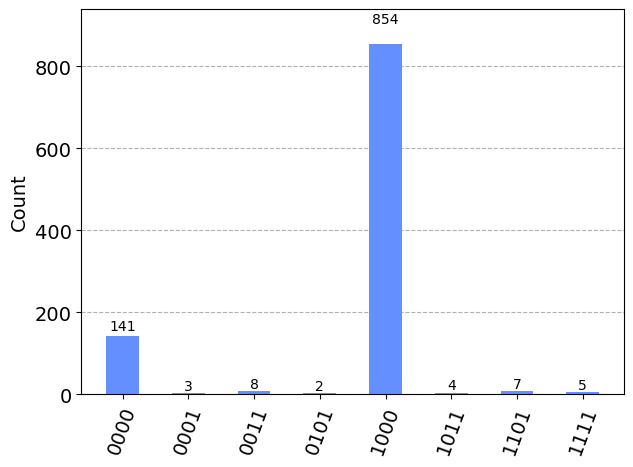

In [77]:
N = 15  # Example number to factor
[qc,a] = shors_algorithm(N)

# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
result = execute(qc, simulator, shots=1024).result()
counts = result.get_counts()

# Display results
print(counts)
print(a)
plot_histogram(counts)

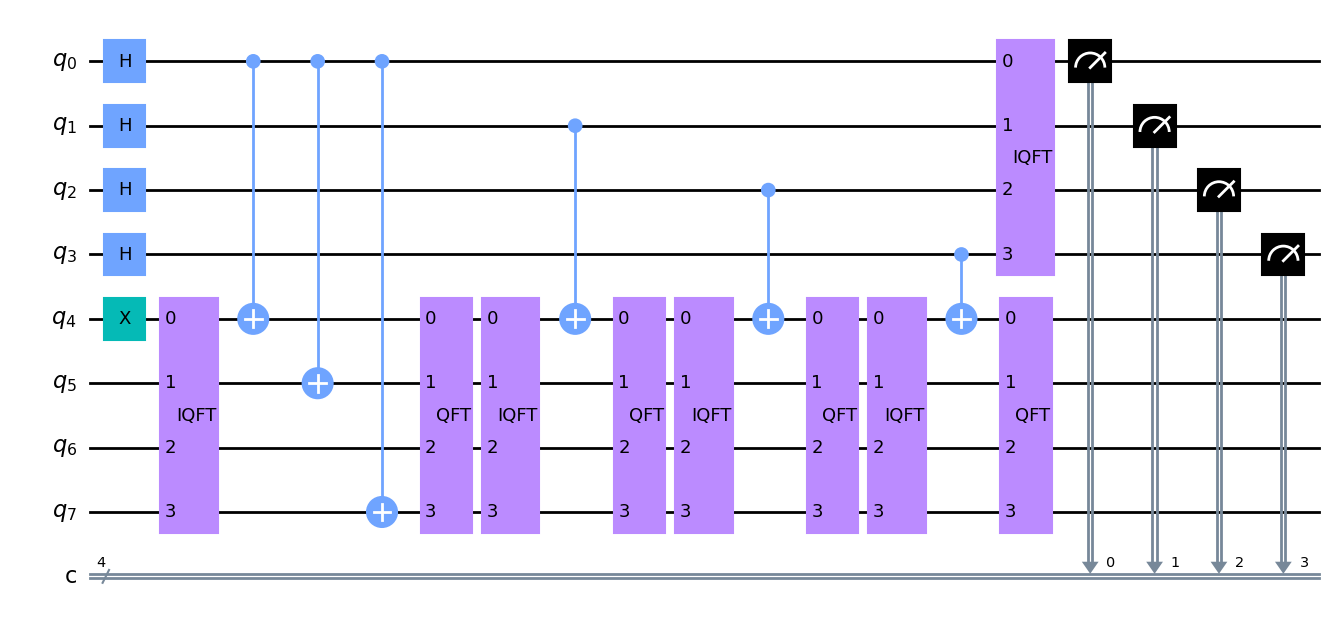

In [78]:
from qiskit.visualization import circuit_drawer
circuit_drawer(qc, output='mpl')

In [61]:
from fractions import Fraction

def continued_fraction_expansion(measured_value, num_qubits):
    """Find the period r using continued fraction expansion."""
    # Compute the estimated fraction s/r from the measured value
    s = measured_value / (2 ** num_qubits)
    
    print(measured_value)
    # Use continued fraction to find the denominator r
    fraction = Fraction(s).limit_denominator()
    print(s)
    print(fraction)
    r = fraction.denominator
    print(r)
    
    return r

def classical_post_processing(counts, a, N):
    """
    Processes quantum measurement results to find period r and compute factors of N.
    """
    num_qubits = int(np.ceil(np.log2(N)))
    
    for measured_str in counts:
        measured_value = int(measured_str, 2)  # Convert binary string to integer
        
        # Find the period r using continued fractions
        r = continued_fraction_expansion(measured_value, num_qubits)
        
        if r % 2 != 0:  # We need r to be even
            continue
        
        # Compute potential factors
        factor1 = gcd(a**(r//2) - 1, N)
        factor2 = gcd(a**(r//2) + 1, N)

        if 1 < factor1 < N:
            return factor1, N // factor1  # Return the nontrivial factors
        
    return "Failed to find factors, try again."

# Example Usage:
#a = 7  # The chosen random number from quantum circuit
#N = 15  # The number we are factoring
#counts = {'0001': 400, '0010': 300, '0100': 200}  # Example simulated result

factors = classical_post_processing(counts, a, N)
print("Factors of", N, "are:", factors)

580
0.1416015625
145/1024
1024
Factors of 3127 are: (53, 59)
